IN THIS NB, WE ARE GONNA DEVELOP A ML MODEL TO THE FEATURE FRAME DATASETS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline


In [2]:
df = pd.read_csv('../../data/feature_frame.csv')

In [3]:
df.dropna().head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [4]:
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
feature_cols = {col for col in df if col not in info_cols + [label_col]}

categorical_cols = ['product_type', 'vendor']
binary_cols= ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = {col for col in feature_cols if col not in categorical_cols + binary_cols}

In [6]:
df[label_col].value_counts()

outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

In [7]:
# get those orders with more than 5 products

items_per_order = df.groupby('order_id').outcome.sum()
big_orders = items_per_order[items_per_order > 5].index

df_2 = df[df['order_id'].isin(big_orders)]

In [8]:
test_df = df_2.groupby('order_id').outcome.sum()
test_df.head(10)

order_id
2807985930372     9.0
2808027644036     6.0
2808099078276     9.0
2808393957508    13.0
2808434524292     7.0
2808548917380     7.0
2808549900420     9.0
2808728715396    12.0
2808769085572    15.0
2808786714756    16.0
Name: outcome, dtype: float64

In [9]:
df_2['order_date'] = pd.to_datetime(df_2['order_date'])

/tmp/ipykernel_67767/1778527225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['order_date'] = pd.to_datetime(df_2['order_date'])


In [10]:
daily_orders = df_2.groupby('order_date').order_id.nunique()

daily_orders.head()

order_date
2020-10-05     3
2020-10-06     7
2020-10-07     5
2020-10-08    10
2020-10-09     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

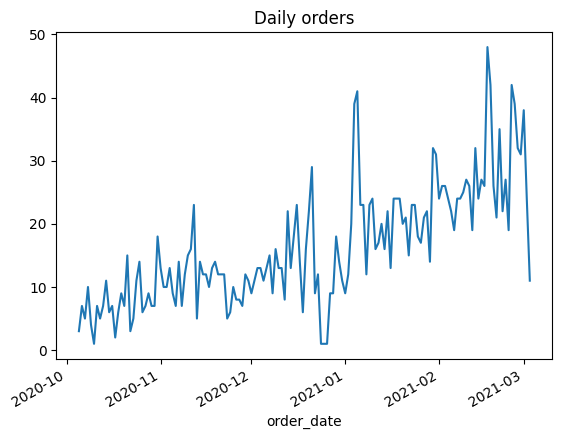

In [11]:
daily_orders.plot()
plt.title('Daily orders')

Must take into account the evolution of the number of orders. Take this in to account when doing the train, validation and test split

In [12]:
df_2 = df_2.sort_values(by='order_date')

In [13]:
n_total = len(df_2)
n_train = int(0.6 * n_total)
n_val = int (0.2 * n_total)

train_df = df_2[:n_train]
val_df = df_2[n_train:n_train + n_val]
test_df = df_2[n_train + n_val:]

We've selected 60/20/20 in order to get enough data for each one of the parts. 10% for test couldn't be enough. We only have 5 months of data.

Now we can start thinking on which predictive and target features are we gonna set.

Categorical wont be added by now

In [14]:
predictive_cols = binary_cols + list(numerical_cols)

In [15]:
X_train = train_df[predictive_cols]
y_train = train_df[label_col]

X_val = val_df[predictive_cols]
y_val = val_df[label_col]

X_test = test_df[predictive_cols]
y_test = test_df[label_col]

In [16]:
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (1213830, 19), y_train shape: (1213830,)
X_val shape: (404610, 19), y_val shape: (404610,)
X_test shape: (404610, 19), y_test shape: (404610,)


In [17]:
# it's not OK because we need to scale with mean and std just of the train data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

Now we are gonna try Ridge, Lasso with some alphas in order to compare the ROC and precision-recall curves. Liblinear solver will be chosen because it fits with both L1 & L2 penalties.

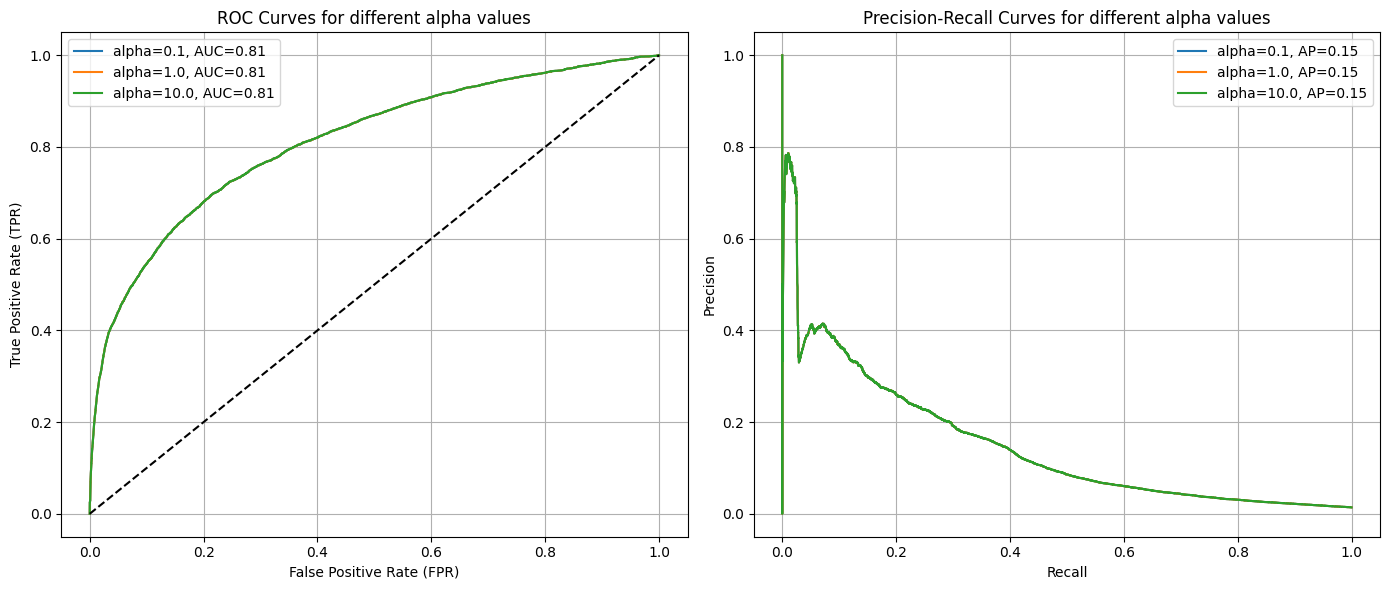

In [18]:
# Alpha values to test
alphas = [0.1, 1.0, 10.0]

# Create a figure with two subplots (one for ROC and another for Precision-Recall)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for alpha in alphas:
    # Create a pipeline with Ridge logistic regression and the specified alpha
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l2', C=1/alpha, solver='liblinear')  # C is 1/alpha
    )
    
    # Train the model
    lr.fit(X_train, y_train)
    
    # Get probabilities for the positive class
    y_val_proba = lr.predict_proba(X_val)[:, 1]
    
    # Calculate metrics for the ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = roc_auc_score(y_val, y_val_proba)
    ax1.plot(fpr, tpr, label=f'alpha={alpha}, AUC={roc_auc:.2f}')
    
    # Calculate metrics for the Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    ap_score = average_precision_score(y_val, y_val_proba)
    ax2.plot(recall, precision, label=f'alpha={alpha}, AP={ap_score:.2f}')

# Configure ROC Curve plot
ax1.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.set_title('ROC Curves for different alpha values')
ax1.legend()
ax1.grid(True)

# Configure Precision-Recall Curve plot
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves for different alpha values')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

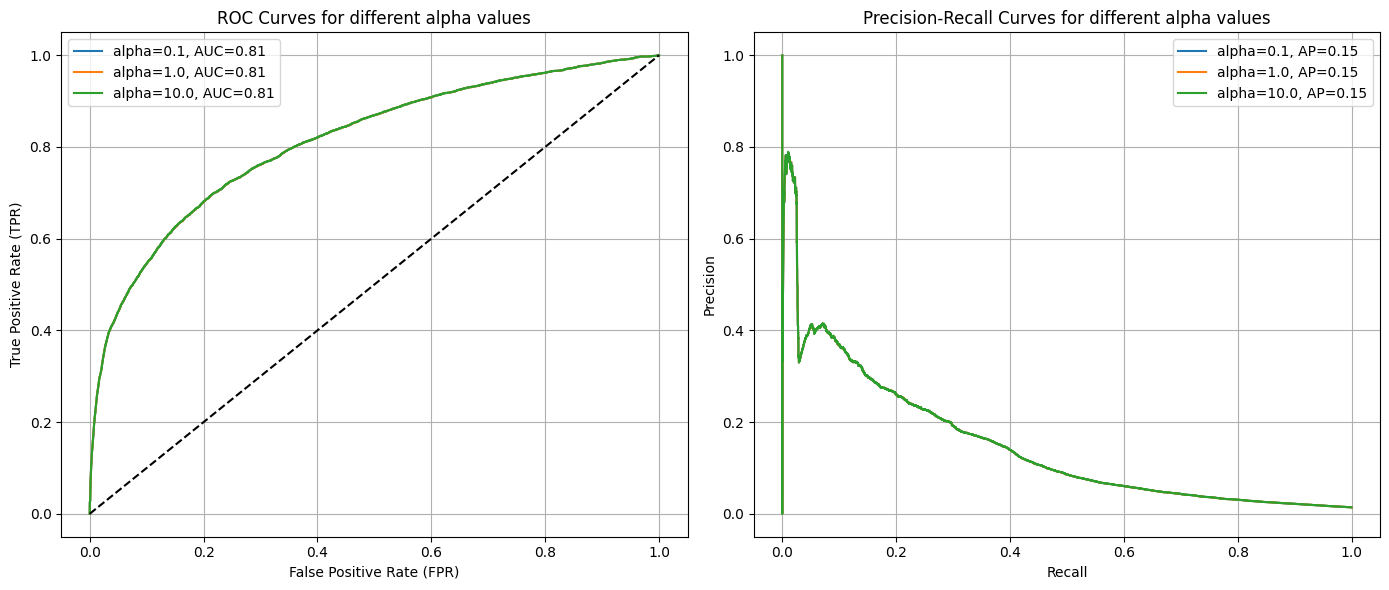

In [19]:
# LASSO REGRESSION

# Alpha values to test
alphas = [0.1, 1.0, 10.0]

# Create a figure with two subplots (one for ROC and another for Precision-Recall)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for alpha in alphas:
    # Create a pipeline with Ridge logistic regression and the specified alpha
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l1', C=1/alpha, solver='liblinear')  # C is 1/alpha
    )
    
    # Train the model
    lr.fit(X_train, y_train)
    
    # Get probabilities for the positive class
    y_val_proba = lr.predict_proba(X_val)[:, 1]
    
    # Calculate metrics for the ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = roc_auc_score(y_val, y_val_proba)
    ax1.plot(fpr, tpr, label=f'alpha={alpha}, AUC={roc_auc:.2f}')
    
    # Calculate metrics for the Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    ap_score = average_precision_score(y_val, y_val_proba)
    ax2.plot(recall, precision, label=f'alpha={alpha}, AP={ap_score:.2f}')

# Configure ROC Curve plot
ax1.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.set_title('ROC Curves for different alpha values')
ax1.legend()
ax1.grid(True)

# Configure Precision-Recall Curve plot
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves for different alpha values')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

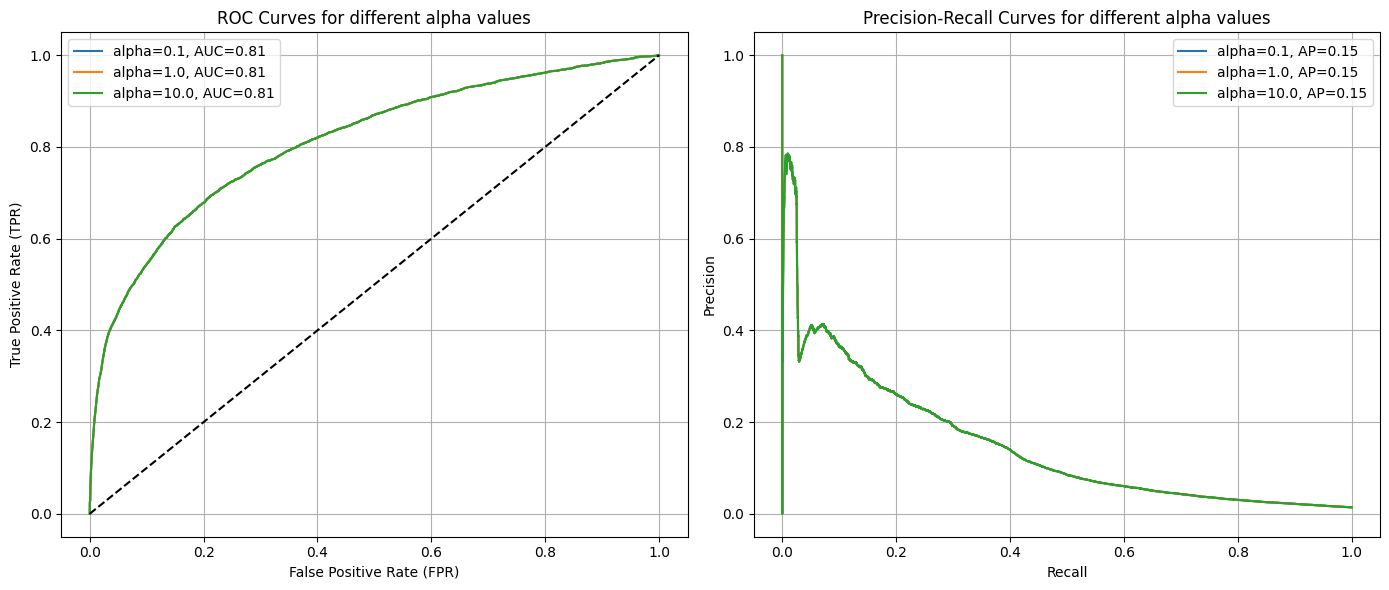

In [20]:
# WITHOUT REGULARIZATION

# Alpha values to test
alphas = [0.1, 1.0, 10.0]

# Create a figure with two subplots (one for ROC and another for Precision-Recall)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for alpha in alphas:
    # Create a pipeline with Ridge logistic regression and the specified alpha
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty=None, solver='lbfgs')  # C is 1/alpha
    )
    
    # Train the model
    lr.fit(X_train, y_train)
    
    # Get probabilities for the positive class
    y_val_proba = lr.predict_proba(X_val)[:, 1]
    
    # Calculate metrics for the ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = roc_auc_score(y_val, y_val_proba)
    ax1.plot(fpr, tpr, label=f'alpha={alpha}, AUC={roc_auc:.2f}')
    
    # Calculate metrics for the Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
    ap_score = average_precision_score(y_val, y_val_proba)
    ax2.plot(recall, precision, label=f'alpha={alpha}, AP={ap_score:.2f}')

# Configure ROC Curve plot
ax1.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.set_title('ROC Curves for different alpha values')
ax1.legend()
ax1.grid(True)

# Configure Precision-Recall Curve plot
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves for different alpha values')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

There is no difference in applying L1, L2 or any regularization. The dataset is big enough to don't need it.s

DIFERENCIAS CON SOLUCION:

- NECESARIO HACER EL ENCODING CATEGORICO
- NECESARIA UNA COMPARACION INICIAL
- NECESARIO HACER UN ANALISIS --> VALDRIAN MENOS VARIABLES PARA EL MISMO RESULTADO